# rsna2018 Notes

This notebook simply provides a few illustrations to go along with the discussion in the README.

I originally thought this notebook would show a lot of the way things were done for the actual project, but as time went on I realized that (a) this wasn't really necessary, and (b) doing so would require including a lot of files in the repository that, again, weren't necessary.

In the end all this notebook shows (besides a bit about the training labels) is, for a small sample of x-rays, a comparison of the "ground truth" boxes with those predicted by my model.  This is interesting to see, and isn't part of the competition itself.

## Training Labels

The labels (in this case, the coordinates of the boxes where human radiologists have diagnosed pneumonia) to go along with the x-rays in the training set are in the CSV file displayed below.

The file contains at least one record for every x-ray in the training set, including those without pneumonia, for which the box coords are empty (NaN).  Since YOLO is a regression technique, those rows are useless for training, so we omit them.

We see that the box info is in units of pixels, and we know from other exploration that x,y pertain to the upper left corner. Also, we see that each row in the table has info for just one box; for x-rays with more than one spot of pneumonia, there are multiple rows in the table. (All of this is knowledge that is gained from EDA.)

In [2]:
import numpy as np
import pandas as pd

df_labels = pd.read_csv('rsna/stage_1_train_labels.csv').dropna()
df_labels.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


## Comparing Model Predictions to Human Diagnosis

At the bottom of this notebook are 6 more-or-less-randomly selected x-rays, showing both the predictions of the model (pink boxes) and the human-diagnosed training labels (blue boxes).

Producing these images was not part of the actual competition workflow, because it required running the finished (trained) model in batch detection mode against images from the training set (so that we have ground truth boxes to compare to.)

For this reason, the comparison might be a little optimistic, since the images are ones the model has been trained on.  Still, it is nice to see a visual comparison, and it does indicate that the training process accomplished something.

And, since I am going through this anyway, I might as well briefly explain the steps.

### Generate List of Sample Patient IDs

The directory `./rsna/sample_jpg` contains the x-rays selected for the comparison. They have already been extracted from the DICOM files into JPGs.

In order to incorporate the ground truth boxes from the labels dataframe above, it will be helpful to have the patient IDs for these x-rays in a dataframe, so read them in and extract the PIDs from the filenames.

In [4]:
import os
from glob import glob

df_sample_list = pd.DataFrame({'file':glob('rsna/sample_jpg/*.jpg')})
df_sample_list['pid'] = df_sample_list['file'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
df_sample_list

,file,pid
0,rsna/sample_jpg/a7b7222f-91db-467e-afb7-68f44f...,a7b7222f-91db-467e-afb7-68f44f06c6a2
1,rsna/sample_jpg/db7bce8f-978c-47b1-8b74-7640f7...,db7bce8f-978c-47b1-8b74-7640f7c3625e
2,rsna/sample_jpg/78dba4d7-e138-4d40-b6a5-ac2d8c...,78dba4d7-e138-4d40-b6a5-ac2d8c65dcf5
3,rsna/sample_jpg/7fb3e6fd-596b-41e7-815b-b2be3f...,7fb3e6fd-596b-41e7-815b-b2be3f856184
4,rsna/sample_jpg/bf9b012d-915c-4026-b989-c05312...,bf9b012d-915c-4026-b989-c05312833b38
5,rsna/sample_jpg/8c984367-b094-429a-b8cf-a9aba9...,8c984367-b094-429a-b8cf-a9aba99e8ff9


### Get Just the Needed Rows from Labels Dataframe

I don't want to work with thousands of rows when I just need a few, so make a list of the PIDs in the above dataframe and use it to make a new dataframe of labels data, having only the rows needed.

We have 4 x-rays with one box and 2 x-rays with 2 boxes, so there should be 8 rows in the result.

In [12]:
sample_pid_list = list(df_sample_list['pid'].values)
df_sample_labels = df_labels[df_labels['patientId'].isin(sample_pid_list)]
df_sample_labels

,patientId,x,y,width,height,Target
11692,78dba4d7-e138-4d40-b6a5-ac2d8c65dcf5,504.0,216.0,224.0,261.0,1
12559,7fb3e6fd-596b-41e7-815b-b2be3f856184,101.0,464.0,229.0,179.0,1
12560,7fb3e6fd-596b-41e7-815b-b2be3f856184,575.0,366.0,189.0,339.0,1
14150,8c984367-b094-429a-b8cf-a9aba99e8ff9,168.0,144.0,247.0,586.0,1
17587,a7b7222f-91db-467e-afb7-68f44f06c6a2,632.0,476.0,277.0,294.0,1
21140,bf9b012d-915c-4026-b989-c05312833b38,194.0,287.0,282.0,476.0,1
21141,bf9b012d-915c-4026-b989-c05312833b38,625.0,281.0,301.0,493.0,1
24426,db7bce8f-978c-47b1-8b74-7640f7c3625e,180.0,502.0,176.0,265.0,1


### Display Comparison Images

Now, grouping by patient ID on the labels dataframe we just created, and using each PID to load the **prediction** image file (the output from the model), display each image and then overlay the ground truth boxes on it.

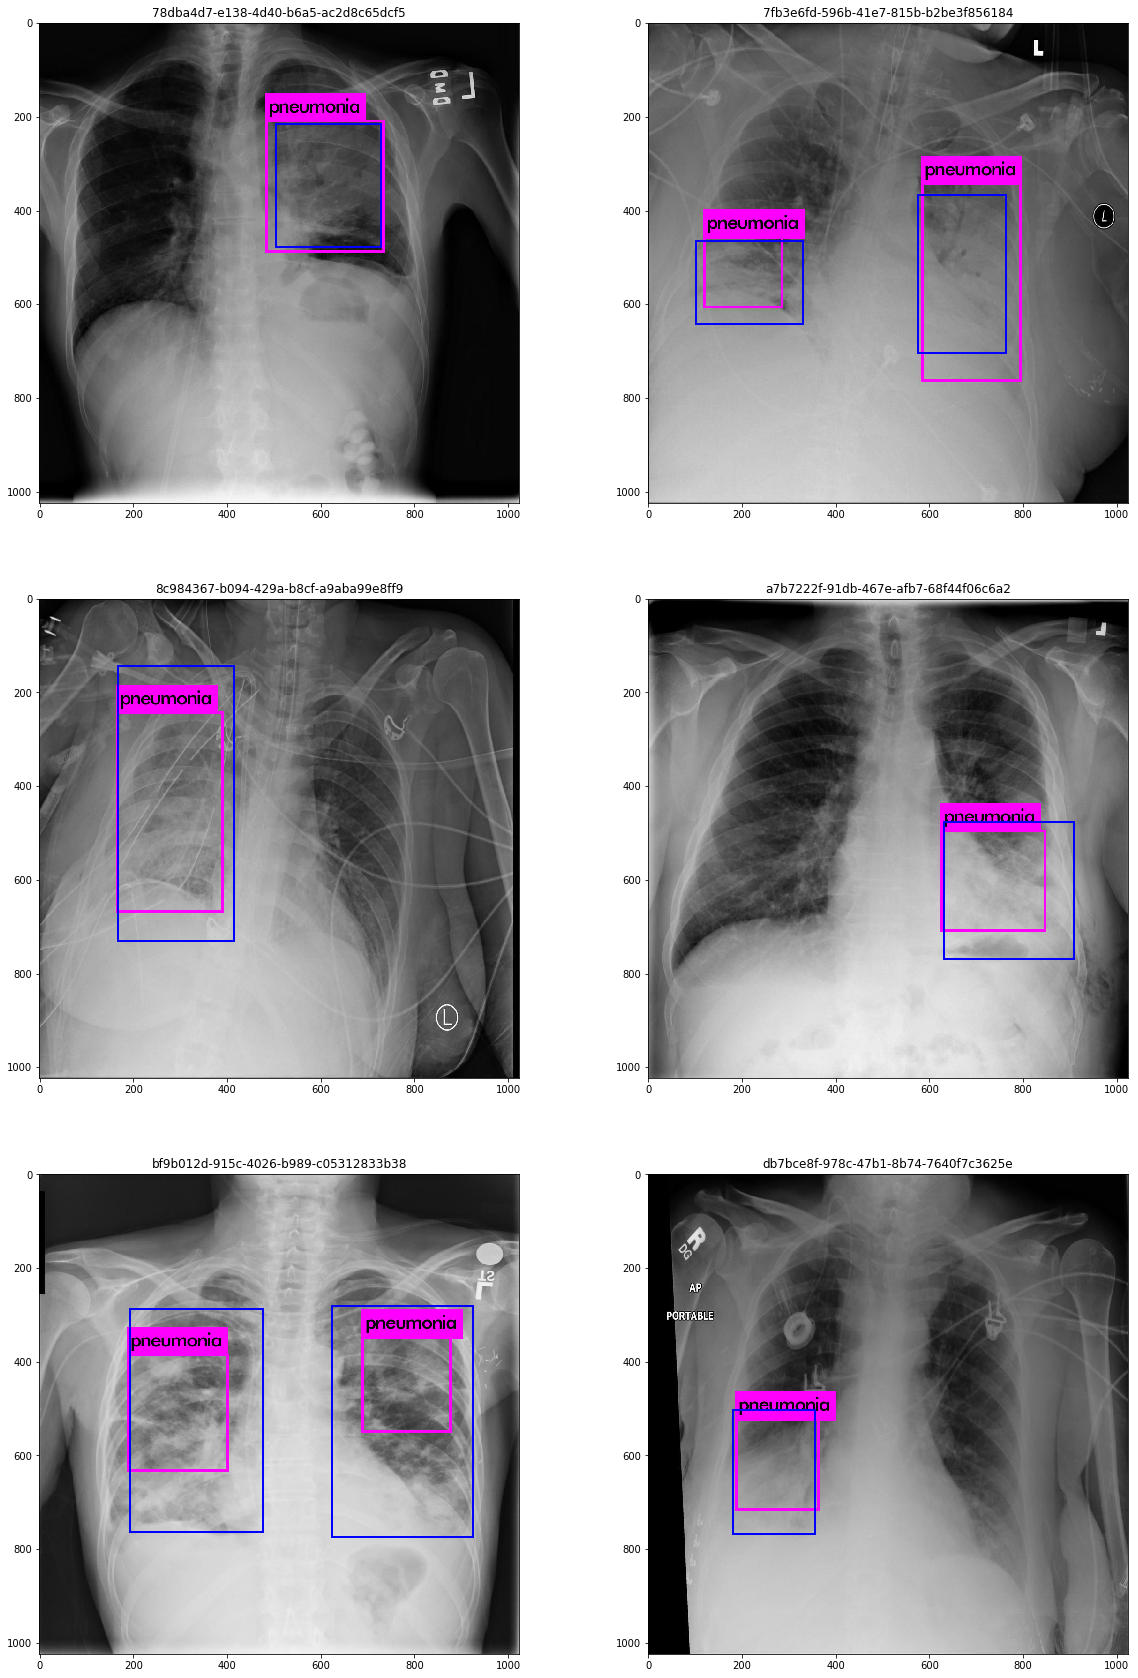

In [21]:
fig, m_axs = plt.subplots(3, 2, figsize = (20, 30))
for c_ax, (pid, rows) in zip(m_axs.flatten(), df_sample_labels.groupby(['patientId'])):
    c_ax.imshow(np.array(Image.open('rsna/sample_pred/{}-pred.jpg'.format(pid))))
    c_ax.set_title(pid)
    for _, row in rows.iterrows():
        c_ax.add_patch(Rectangle((row['x'],row['y']), row['width'], row['height'], 
                    linewidth=2, edgecolor='b', facecolor='none'))